<a href="https://colab.research.google.com/github/Upendran1803/Computer-Vision-1/blob/main/Market_Breadth_Indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:$ZOMATO.NS: possibly delisted; no timezone found


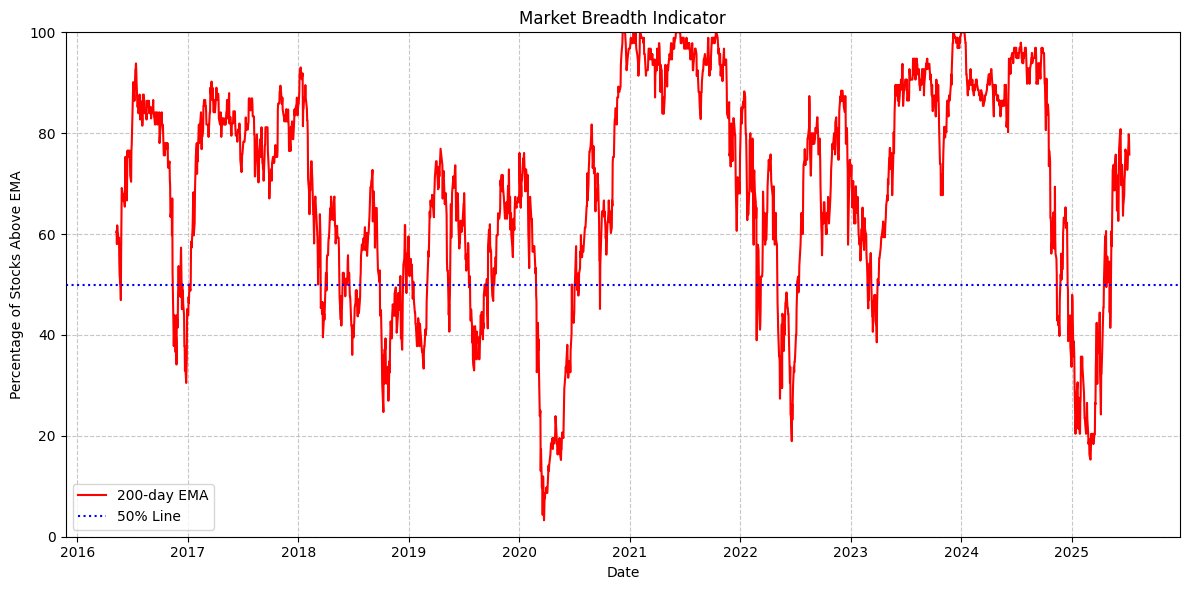

Latest percentage above 50-day EMA: 76.77%
Latest percentage above 200-day EMA: 75.76%


In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta

def get_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365*10)
        hist = stock.history(start=start_date, end=end_date)
        return hist['Close']
    except:
        return None

def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def is_above_ema(ticker):
    data = get_stock_data(ticker)
    if data is None or len(data) < 200:
        return None

    # Drop any NaN values
    data = data.dropna()

    if len(data) < 200:  # Double-check after dropping NaN
        return None

    ema_50 = calculate_ema(data, 50)
    ema_200 = calculate_ema(data, 200)

    # Wait for EMA to establish (first 200 days)
    start_idx = 199  # 0-based indexing

    above_50 = data[start_idx:] > ema_50[start_idx:]
    above_200 = data[start_idx:] > ema_200[start_idx:]

    return above_50, above_200

def calculate_market_breadth(tickers):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(is_above_ema, tickers))

    valid_results = [r for r in results if r is not None]

    df_50 = pd.concat([r[0] for r in valid_results], axis=1)
    df_200 = pd.concat([r[1] for r in valid_results], axis=1)

    # Calculate the percentage above EMAs
    percent_above_50 = df_50.mean(axis=1) * 100
    percent_above_200 = df_200.mean(axis=1) * 100

    # Drop any rows where all values are NaN
    percent_above_50 = percent_above_50.dropna()
    percent_above_200 = percent_above_200.dropna()

    # Remove initial zero values
    if len(percent_above_200) > 0:
        # Find the first non-zero value
        first_valid_idx = percent_above_200[percent_above_200 != 0].index[0]
        percent_above_50 = percent_above_50[first_valid_idx:]
        percent_above_200 = percent_above_200[first_valid_idx:]

    return percent_above_50, percent_above_200

# NSE tickers list
nse_tickers = ['ABB.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS',
               'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'AMBUJACEM.NS',
               'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'DMART.NS', 'AXISBANK.NS',
               'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS',
               'BANKBARODA.NS', 'BEL.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS',
               'BOSCHLTD.NS', 'BRITANNIA.NS', 'CANBK.NS', 'CHOLAFIN.NS', 'CIPLA.NS',
               'COALINDIA.NS', 'DLF.NS', 'DABUR.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
               'EICHERMOT.NS', 'GAIL.NS', 'GODREJCP.NS', 'GRASIM.NS', 'HCLTECH.NS',
               'HDFCBANK.NS', 'HDFCLIFE.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS',
               'HINDALCO.NS', 'HAL.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ICICIGI.NS',
               'ICICIPRULI.NS', 'ITC.NS', 'IOC.NS', 'IRCTC.NS', 'IRFC.NS',
               'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INDIGO.NS', 'JSWENERGY.NS',
               'JSWSTEEL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'KOTAKBANK.NS', 'LTIM.NS',
               'LT.NS', 'LICI.NS', 'LODHA.NS', 'M&M.NS', 'MARUTI.NS', 'NHPC.NS',
               'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'PIDILITIND.NS', 'PFC.NS',
               'POWERGRID.NS', 'PNB.NS', 'RECLTD.NS', 'RELIANCE.NS', 'SBILIFE.NS',
               'MOTHERSON.NS', 'SHREECEM.NS', 'SHRIRAMFIN.NS', 'SIEMENS.NS', 'SBIN.NS',
               'SUNPHARMA.NS', 'TVSMOTOR.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS',
               'TATAPOWER.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TORNTPHARM.NS',
               'TRENT.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UNITDSPR.NS', 'VBL.NS',
               'VEDL.NS', 'WIPRO.NS', 'ZOMATO.NS', 'ZYDUSLIFE.NS']

# Calculate market breadth
percent_above_50, percent_above_200 = calculate_market_breadth(nse_tickers)

# Plotting
if len(percent_above_200) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(percent_above_200.index, percent_above_200, color='red', label='200-day EMA')
    plt.axhline(y=50, color='blue', linestyle=':', label='50% Line')

    plt.title('Market Breadth Indicator')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Stocks Above EMA')
    plt.legend()
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print the latest values
    print(f"Latest percentage above 50-day EMA: {percent_above_50.iloc[-1]:.2f}%")
    print(f"Latest percentage above 200-day EMA: {percent_above_200.iloc[-1]:.2f}%")
else:
    print("No valid data points to plot")

In [3]:
!pip install yfinance plotly --quiet

import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta

def get_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365*10)
        hist = stock.history(start=start_date, end=end_date)
        return hist['Close']
    except:
        return None

def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def is_above_ema(ticker):
    data = get_stock_data(ticker)
    if data is None or len(data) < 200:
        return None

    data = data.dropna()
    if len(data) < 200:
        return None

    ema_50 = calculate_ema(data, 50)
    ema_200 = calculate_ema(data, 200)

    start_idx = 199
    above_50 = data[start_idx:] > ema_50[start_idx:]
    above_200 = data[start_idx:] > ema_200[start_idx:]

    return above_50, above_200

def calculate_market_breadth(tickers):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(is_above_ema, tickers))

    valid_results = [r for r in results if r is not None]

    df_50 = pd.concat([r[0] for r in valid_results], axis=1)
    df_200 = pd.concat([r[1] for r in valid_results], axis=1)

    percent_above_50 = df_50.mean(axis=1) * 100
    percent_above_200 = df_200.mean(axis=1) * 100

    percent_above_50 = percent_above_50.dropna()
    percent_above_200 = percent_above_200.dropna()

    if len(percent_above_200) > 0:
        first_valid_idx = percent_above_200[percent_above_200 != 0].index[0]
        percent_above_50 = percent_above_50[first_valid_idx:]
        percent_above_200 = percent_above_200[first_valid_idx:]

    return percent_above_50, percent_above_200

# NSE tickers list (shortened for example speed)
nse_tickers = ['ABB.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS',
               'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'AMBUJACEM.NS',
               'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'DMART.NS', 'AXISBANK.NS',
               'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS',
               'BANKBARODA.NS', 'BEL.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS',
               'BOSCHLTD.NS', 'BRITANNIA.NS', 'CANBK.NS', 'CHOLAFIN.NS', 'CIPLA.NS',
               'COALINDIA.NS', 'DLF.NS', 'DABUR.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
               'EICHERMOT.NS', 'GAIL.NS', 'GODREJCP.NS', 'GRASIM.NS', 'HCLTECH.NS',
               'HDFCBANK.NS', 'HDFCLIFE.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS',
               'HINDALCO.NS', 'HAL.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ICICIGI.NS',
               'ICICIPRULI.NS', 'ITC.NS', 'IOC.NS', 'IRCTC.NS', 'IRFC.NS',
               'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INDIGO.NS', 'JSWENERGY.NS',
               'JSWSTEEL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'KOTAKBANK.NS', 'LTIM.NS',
               'LT.NS', 'LICI.NS', 'LODHA.NS', 'M&M.NS', 'MARUTI.NS', 'NHPC.NS',
               'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'PIDILITIND.NS', 'PFC.NS',
               'POWERGRID.NS', 'PNB.NS', 'RECLTD.NS', 'RELIANCE.NS', 'SBILIFE.NS',
               'MOTHERSON.NS', 'SHREECEM.NS', 'SHRIRAMFIN.NS', 'SIEMENS.NS', 'SBIN.NS',
               'SUNPHARMA.NS', 'TVSMOTOR.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS',
               'TATAPOWER.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TORNTPHARM.NS',
               'TRENT.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UNITDSPR.NS', 'VBL.NS',
               'VEDL.NS', 'WIPRO.NS', 'ZOMATO.NS', 'ZYDUSLIFE.NS']

# Calculate market breadth
percent_above_50, percent_above_200 = calculate_market_breadth(nse_tickers)

# Plotting with Plotly
if len(percent_above_200) > 0:
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=percent_above_200.index,
        y=percent_above_200,
        mode='lines',
        name='200-day EMA',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=percent_above_50.index,
        y=percent_above_50,
        mode='lines',
        name='50-day EMA',
        line=dict(color='green')
    ))

    fig.add_hline(y=50, line=dict(color='blue', dash='dot'), name='50% Line')

    fig.update_layout(
        title='Market Breadth Indicator (Plotly)',
        xaxis_title='Date',
        yaxis_title='Percentage of Stocks Above EMA',
        yaxis_range=[0, 100],
        template='plotly_white',
        height=600
    )

    fig.show()

    print(f"Latest percentage above 50-day EMA: {percent_above_50.iloc[-1]:.2f}%")
    print(f"Latest percentage above 200-day EMA: {percent_above_200.iloc[-1]:.2f}%")
else:
    print("No valid data points to plot.")


ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:$ZOMATO.NS: possibly delisted; no timezone found


Latest percentage above 50-day EMA: 76.77%
Latest percentage above 200-day EMA: 75.76%
